In [1]:
import pandas as pd
print(pd.__version__)


2.3.1


In [3]:

import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Torch version: 2.8.0+cu129
CUDA available: True
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


Rows,Cols: (83448, 2)
label
1    43910
0    39538
Name: count, dtype: int64


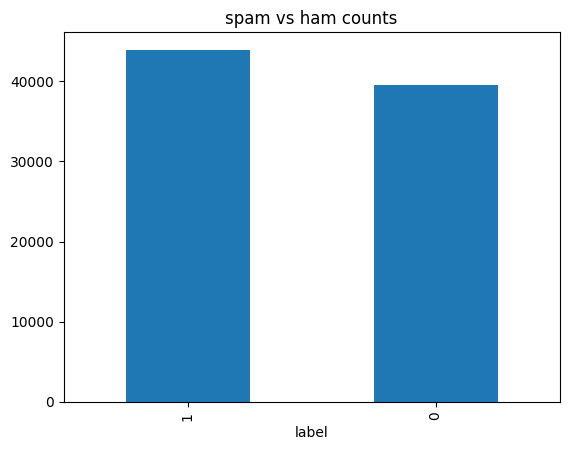

In [4]:
# Step 0: load and basic EDA
!pip install pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("combined_data.csv")    # change to your filename
print("Rows,Cols:", df.shape)
print(df['label'].value_counts())

# quick plot of class balance
df['label'].value_counts().plot(kind='bar', title='spam vs ham counts')
plt.show()


In [5]:
# Step 1: preprocessing
import re
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def clean_text(s, remove_stopwords=True):
    s = str(s).lower()
    s = re.sub(r'<[^>]+>', ' ', s)            # remove HTML
    s = re.sub(r'http\S+', ' url ', s)        # urls => token
    s = re.sub(r'[^a-z0-9\s]', ' ', s)        # punctuation -> space
    s = re.sub(r'\s+', ' ', s).strip()
    if remove_stopwords:
        s = ' '.join(w for w in s.split() if w not in stop)
    return s

df = df.dropna(subset=['text','label']).drop_duplicates().reset_index(drop=True)
df['clean'] = df['text'].apply(clean_text)
# Ensure labels are 0/1
if df['label'].dtype == object:
    df['y'] = df['label'].map(lambda x: 1 if str(x).lower().strip() in ('spam','1','true','yes') else 0)
else:
    df['y'] = df['label'].astype(int)

print("After cleaning:", df.shape)
df.sample(5)


After cleaning: (83448, 4)


,label,text,clean,y
8066,0,test failed original message from jim wantz to...,test failed original message jim wantz sent fr...,0
62712,0,vince :\ncan you tell me where to get this inf...,vince tell get info forwarded shirley crenshaw...,0
36198,1,"we have $ 100 worth of coke ® , pepsi ® , or a...",100 worth coke pepsi restaurant gift card opin...,1
76064,1,free escapenumber escapenumber poker tournamen...,free escapenumber escapenumber poker tournamen...,1
62750,1,opt - in email special offer unsubscribe me se...,opt email special offer unsubscribe search sof...,1


In [6]:
from sklearn.model_selection import train_test_split
X = df['clean']
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (66758,) Test: (16690,)


In [7]:
# Step 3: TF-IDF (used for NB, SVM)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)

# Optionally keep a Count vectorizer for experiments
bow_vectorizer = CountVectorizer(max_features=20000, ngram_range=(1,2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow  = bow_vectorizer.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)


TF-IDF shape: (66758, 20000)


In [8]:
# Step 4: Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)

nb_preds = nb_model.predict(X_test_tfidf)
nb_probs = nb_model.predict_proba(X_test_tfidf)[:,1]

print("Naive Bayes")
print("Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, nb_probs))

# Save model + vectorizer
#import joblib
#joblib.dump(nb_model, "nb_model.joblib")
#joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.joblib")


Naive Bayes
Accuracy: 0.9744757339724386
              precision    recall  f1-score   support

           0     0.9648    0.9819    0.9733      7908
           1     0.9835    0.9678    0.9756      8782

    accuracy                         0.9745     16690
   macro avg     0.9741    0.9748    0.9744     16690
weighted avg     0.9746    0.9745    0.9745     16690

ROC-AUC: 0.9968562258963735


In [9]:
# Step 5: Linear SVM with CalibratedClassifierCV for probabilities
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Note: don't always scale TF-IDF; we used with_mean=False scaler only if needed. Many use raw TF-IDF.
linear = LinearSVC(max_iter=10000)
svm_clf = CalibratedClassifierCV(linear, cv=3)   # calibrate for predict_proba
svm_clf.fit(X_train_tfidf, y_train)  # uses TF-IDF directly

svm_preds = svm_clf.predict(X_test_tfidf)
svm_probs = svm_clf.predict_proba(X_test_tfidf)[:,1]

print("SVM")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, svm_probs))

#joblib.dump(svm_clf, "svm_clf.joblib")


SVM
Accuracy: 0.9913121629718394
              precision    recall  f1-score   support

           0     0.9928    0.9889    0.9908      7908
           1     0.9900    0.9935    0.9918      8782

    accuracy                         0.9913     16690
   macro avg     0.9914    0.9912    0.9913     16690
weighted avg     0.9913    0.9913    0.9913     16690

ROC-AUC: 0.9987369120886551


In [10]:
# Step 6: LSTM (Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

MAX_WORDS = 20000
MAX_LEN = 150
EMB_DIM = 128

tokenizer_keras = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer_keras.fit_on_texts(X_train)

Xtr_seq = tokenizer_keras.texts_to_sequences(X_train)
Xte_seq = tokenizer_keras.texts_to_sequences(X_test)
Xtr_pad = pad_sequences(Xtr_seq, maxlen=MAX_LEN, padding='post', truncating='post')
Xte_pad = pad_sequences(Xte_seq, maxlen=MAX_LEN, padding='post', truncating='post')

model_lstm = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMB_DIM, input_length=MAX_LEN),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_lstm.fit(Xtr_pad, y_train.values, validation_split=0.1, epochs=5, batch_size=64, callbacks=[es])

dl_probs = model_lstm.predict(Xte_pad).flatten()
dl_preds = (dl_probs > 0.5).astype(int)

print("LSTM")
print("Accuracy:", accuracy_score(y_test, dl_preds))
print(classification_report(y_test, dl_preds, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, dl_probs))

# Save tokenizer and model
#import json
#with open("keras_tokenizer.json","w") as f:
    #f.write(tokenizer_keras.to_json())
#model_lstm.save("lstm_model.h5")


c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 909s 951ms/step - accuracy: 0.8964 - loss: 0.2720 - val_accuracy: 0.9732 - val_loss: 0.0918
Epoch 2/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 304s 324ms/step - accuracy: 0.9815 - loss: 0.0650 - val_accuracy: 0.9877 - val_loss: 0.0439
Epoch 3/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 404s 431ms/step - accuracy: 0.9899 - loss: 0.0351 - val_accuracy: 0.9886 - val_loss: 0.0472
Epoch 4/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 445s 474ms/step - accuracy: 0.9942 - loss: 0.0236 - val_accuracy: 0.9891 - val_loss: 0.0402
Epoch 5/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 292s 311ms/step - accuracy: 0.9951 - loss: 0.0202 - val_accuracy: 0.9871 - val_loss: 0.0526
522/522 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step
LSTM
Accuracy: 0.9891551827441581
              precision    recall  f1-score   support

           0     0.9919    0.9852    0.9885      7908
           1     0.9868    0.9927    0.9897      8782

    accuracy                         0.9892     16690
   macro avg     0.9893    0.9890    0.9891     16

In [ ]:
! pip install torch transformers datasets evaluate accelerate


In [8]:
!pip show transformers


Name: transformers
Version: 4.56.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: C:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [13]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu129

Looking in indexes: https://download.pytorch.org/whl/cu129
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.1 MB 5.5 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.1 MB 5.6 MB/s eta 0:00:01
   ----------------------- ---------------- 4.7/8.1 MB 5.7 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 5.6 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.1 MB 5.8 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 5.4 MB/s  0:00:01
   ---------------------------------------- 0.0/3.6 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.6 GB ? eta -:--:--
   ---------------------------------------- 0.0/3.6 GB 6.6 MB/s eta 0:09:05
   ---------------------------------------- 0.0/3.6 GB 6.8 M

  You can safely remove it manually.


In [11]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4050 Laptop GPU


In [12]:
# Step 7A: Prepare PyTorch-style Dataset for Trainer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np

model_name = "distilbert-base-uncased"
tokenizer_hf = AutoTokenizer.from_pretrained(model_name)

class TorchSpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        item = {k:v.squeeze(0) for k,v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = TorchSpamDataset(X_train, y_train, tokenizer_hf, max_len=128)
eval_dataset  = TorchSpamDataset(X_test, y_test, tokenizer_hf, max_len=128)

# Step 7B: Load model and training args
model_hf = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # <-- correct for new versions
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir='./logs',
    report_to=[]    # set to "wandb" if using wandb (and have wandb.init earlier)
)

# compute_metrics using sklearn
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

def compute_metrics_hf(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    # Softmax probs for class 1
    probs = np.exp(logits) / np.exp(logits).sum(-1, keepdims=True)
    try:
        roc = roc_auc_score(labels, probs[:,1])
    except:
        roc = None
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc}

trainer = Trainer(
    model=model_hf,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics_hf
)

# If you have GPU and proper torch, this will use it. Else it runs on CPU (slow).
trainer.train()

# Evaluate + preds
res = trainer.evaluate()
pred_out = trainer.predict(eval_dataset)
bert_logits = pred_out.predictions
bert_preds = np.argmax(bert_logits, axis=-1)
# compute probs (softmax)
import torch as t
bert_probs = t.nn.functional.softmax(t.tensor(bert_logits), dim=-1).numpy()[:,1]

print("Transformer (DistilBERT) eval:", res)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
#399e9ac7b04d7e4a228d1eb1a3eff8cb58b50494
# Step 8: collect metrics for each model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

rows = []
def add_row(name, y_true, preds, probs):
    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, preds),
        "Precision": precision_score(y_true, preds, zero_division=0),
        "Recall": recall_score(y_true, preds, zero_division=0),
        "F1": f1_score(y_true, preds, zero_division=0),
        "ROC_AUC": roc_auc_score(y_true, probs) if probs is not None else None
    })

add_row("NaiveBayes", y_test, nb_preds, nb_probs)
add_row("SVM", y_test, svm_preds, svm_probs)
add_row("LSTM", y_test, dl_preds, dl_probs)
add_row("DistilBERT", y_test, bert_preds, bert_probs)

comparison_df = pd.DataFrame(rows).set_index("Model")
print(comparison_df)


            Accuracy  Precision    Recall        F1   ROC_AUC
Model                                                        
NaiveBayes  0.974476   0.983453  0.967775  0.975551  0.996857
SVM         0.991312   0.990015  0.993509  0.991759  0.998735
LSTM        0.987058   0.983299  0.992257  0.987758  0.997991
DistilBERT  0.991312   0.989016  0.994534  0.991767  0.999117


In [ ]:
# Step 8B: Visual comparison of model performance
plt.figure(figsize=(10,6))
comparison_df[['Accuracy','Precision','Recall','F1']].plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.8, 1.0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Step 8C: Accuracy-only comparison
plt.figure(figsize=(6,5))
plt.bar(comparison_df.index, comparison_df['Accuracy'], color=['skyblue','lightgreen','salmon','violet'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
for i, acc in enumerate(comparison_df['Accuracy']):
    plt.text(i, acc + 0.002, f"{acc*100:.2f}%", ha='center', fontsize=11)
plt.show()


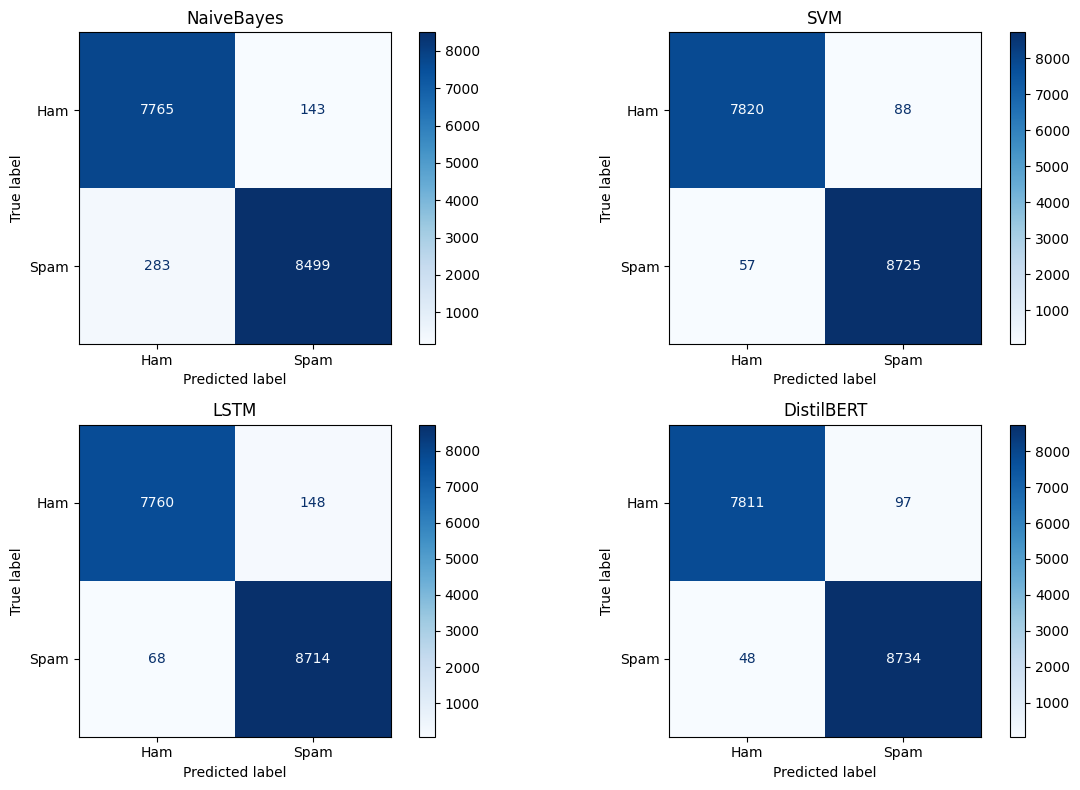

In [ ]:
# Step 9: confusion matrices for each model (2x2 grid)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
models = {
    "NaiveBayes": (nb_preds),
    "SVM": (svm_preds),
    "LSTM": (dl_preds),
    "DistilBERT": (bert_preds)
}

plt.figure(figsize=(12,8))
i = 1
for name, preds in models.items():
    cm = confusion_matrix(y_test, preds)
    ax = plt.subplot(2,2,i)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Ham','Spam'])
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    ax.set_title(name)
    i += 1
plt.tight_layout()
plt.show()


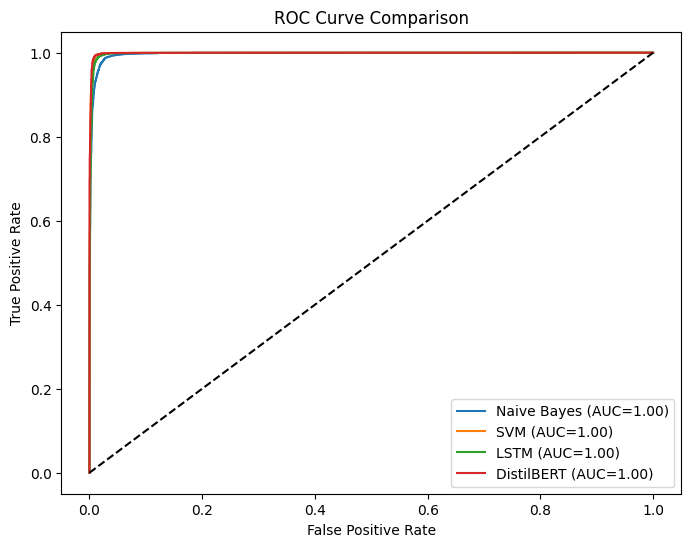

In [ ]:
# Step 10: ROC curve for all models
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(8,6))

fpr, tpr, _ = roc_curve(y_test, nb_probs); plt.plot(fpr, tpr, label=f"Naive Bayes (AUC={auc(fpr,tpr):.2f})")
fpr, tpr, _ = roc_curve(y_test, svm_probs); plt.plot(fpr, tpr, label=f"SVM (AUC={auc(fpr,tpr):.2f})")
fpr, tpr, _ = roc_curve(y_test, dl_probs);  plt.plot(fpr, tpr, label=f"LSTM (AUC={auc(fpr,tpr):.2f})")
fpr, tpr, _ = roc_curve(y_test, bert_probs);plt.plot(fpr, tpr, label=f"DistilBERT (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Step 11: Save best model (example: save transformer or NB)
# NB already saved. For transformer, save locally:
#model_hf.save_pretrained("./spam_model_hf")
#tokenizer_hf.save_pretrained("./spam_model_hf")

# Minimal predict function examples:
def predict_with_nb(text):
    v = tfidf_vectorizer.transform([clean_text(text)])
    p = nb_model.predict(v)[0]
    prob = nb_model.predict_proba(v)[0][1]
    return p, prob

def predict_with_transformer(text, device='cpu'):
    enc = tokenizer_hf(clean_text(text), truncation=True, padding='max_length', max_length=128, return_tensors='pt')
    enc = {k: v.to(device) for k,v in enc.items()}
    model_hf.to(device)
    with torch.no_grad():
        out = model_hf(**enc)
        probs = torch.nn.functional.softmax(out.logits, dim=-1).cpu().numpy()[0]
        pred = np.argmax(out.logits.cpu().numpy(), axis=-1)[0]
    return pred, probs[1]


In [ ]:
# Step 12: User input for prediction
print("\n=== Email Spam Detection (Main Model: DistilBERT Transformer) ===")
while True:
    text = input("\nEnter an email/message (or type 'exit' to quit): ")
    if text.lower() == 'exit':
        print("Exiting...")
        break
    pred, prob = predict_with_transformer(text)
    label = "SPAM" if pred == 1 else "HAM (Not Spam)"
    print(f"\nPrediction: {label}")
    print(f"Confidence: {prob*100:.2f}%")
